In [25]:
%matplotlib inline
%pylab inline

import menpo.io as mio
from menpo.feature import fast_dsift, no_op, hog

from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images

from menpofit.aam import (
    AAMBuilder,
    LucasKanadeAAMFitter)
from menpofit.lucaskanade import SIC
from menpofit.visualize import visualize_fitting_result, plot_ced

Populating the interactive namespace from numpy and matplotlib


## Load training data

In [2]:
training_images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/trainset/', 
                           verbose=True, max_images=None):
    i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_66)
    if i.n_channels == 3:
        i = i.as_greyscale(mode='average')
    training_images.append(i)

Importing assets: [==========] 100% (811/811) - 00:00:00 remaining


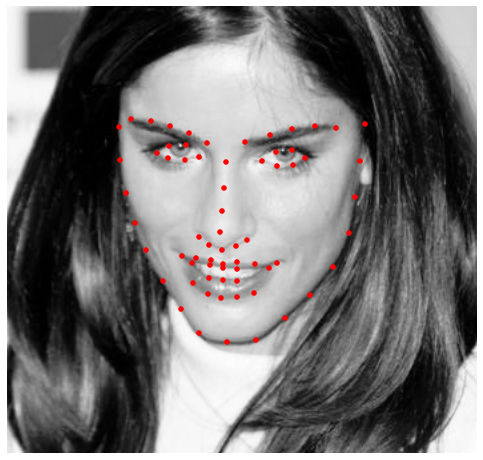

In [3]:
visualize_images(training_images)

## Load test data

In [4]:
test_images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/testset/', 
                           verbose=True, max_images=None):    
    i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_66)
    if i.n_channels == 3:
        i = i.as_greyscale(mode='average')
    test_images.append(i)

Importing assets: [==========] 100% (224/224) - 00:00:00 remaining


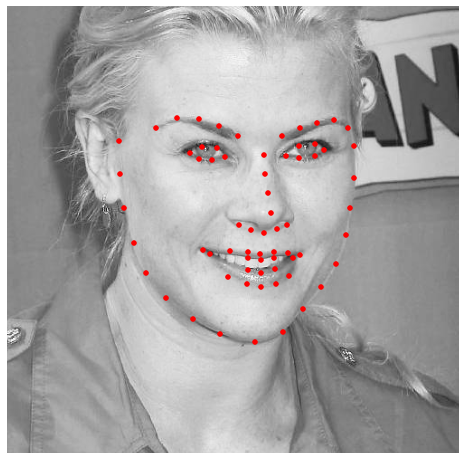

In [5]:
visualize_images(test_images)

## Build Active Appearance Models

In [6]:
features = fast_dsift
normalization_diagonal = 100
n_levels = 2
downscale = 2
scaled_shape_models = False
scale_features = True
max_shape_components= 25
max_appearance_components = 200

#### AAM

In [7]:
aam_builder = AAMBuilder(
    features=features,
    normalization_diagonal=normalization_diagonal, 
    n_levels=n_levels,
    downscale=downscale, 
    scaled_shape_models=scaled_shape_models,
    max_shape_components=max_shape_components,
    max_appearance_components=max_appearance_components)

aam = aam_builder.build(
    training_images, 
    group='ibug_face_66', 
    verbose=True)

- Normalizing images size: Done
- Building model for each of the 2 pyramid levels
  - Level 1: Done
  - Level 2: Done


## Fit Active Appearance Models

In [8]:
algorithm = SIC

#### AAM Fitter

In [38]:
aam_fitter = LucasKanadeAAMFitter(
    aam, 
    algorithm=algorithm, 
    n_shape=[5, 15], 
    n_appearance=[50, 100])

#### Fitting loop

In [39]:
fitters = [aam_fitter]
           
fitters_results = []

for j, i in enumerate(test_images):
    
    gt_s = i.landmarks['ibug_face_66'].lms
    np.random.seed(2)
    s = aam_fitter.noisy_shape_from_shape(gt_s, noise_std=0.02)

    fr = aam_fitter.fit(i, s, gt_shape=gt_s, max_iters=20) 
    fitters_results.append(fr)

    print 'Image: ', j
    print fr

Image:  0
Fitting Result
 - Initial error: 0.0780
 - Final error: 0.0168
 - LK-AAM-Simultaneous-IC method with 2 pyramid levels, 20 iterations and using fast_dsift features.
Image:  1
Fitting Result
 - Initial error: 0.0744
 - Final error: 0.0149
 - LK-AAM-Simultaneous-IC method with 2 pyramid levels, 20 iterations and using fast_dsift features.
Image:  2
Fitting Result
 - Initial error: 0.0830
 - Final error: 0.0430
 - LK-AAM-Simultaneous-IC method with 2 pyramid levels, 20 iterations and using fast_dsift features.
Image:  3
Fitting Result
 - Initial error: 0.0980
 - Final error: 0.0230
 - LK-AAM-Simultaneous-IC method with 2 pyramid levels, 20 iterations and using fast_dsift features.
Image:  4
Fitting Result
 - Initial error: 0.1583
 - Final error: 0.0272
 - LK-AAM-Simultaneous-IC method with 2 pyramid levels, 20 iterations and using fast_dsift features.
Image:  5
Fitting Result
 - Initial error: 0.1542
 - Final error: 0.0282
 - LK-AAM-Simultaneous-IC method with 2 pyramid levels, 2

## Results

In [45]:
initial_errors = [fr.initial_error() for fr in fitters_results]
final_errors = [fr.final_error() for fr in fitters_results]

errors = [initial_errors, final_errors]

In [46]:
print 'mean_1:', np.mean(final_errors), 'std_1:', np.std(final_errors)

mean_1: 0.0454017848552 std_1: 0.0521871814447


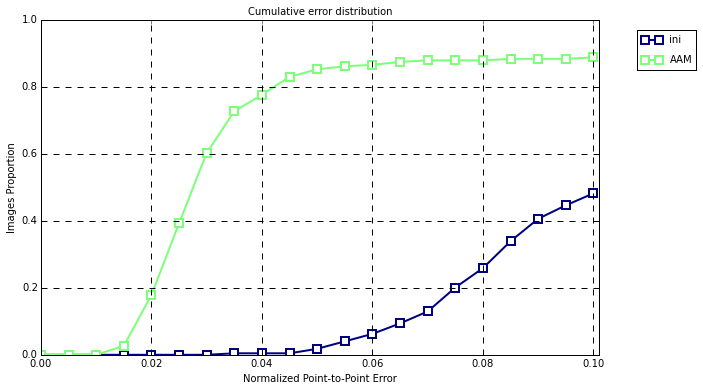

In [47]:
plot_ced(errors, legend_entries=['ini', 'AAM'])

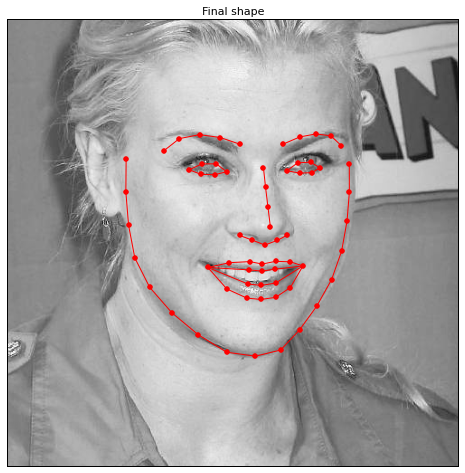

In [43]:
visualize_fitting_result(fitters_results)

In [44]:
%timeit fr = aam_fitter.fit(i, s, gt_shape=gt_s, max_iters=20) 

1 loops, best of 3: 554 ms per loop
